In [59]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [60]:
workdir = "/Users/emre/GitHub/HU-AI/AIN432/Assignment 2/"
IMAGES_LOCATION = os.path.join(workdir, "images/full-size")

In [61]:
def read_directory(directory_name):
    return sorted(os.listdir(directory_name))

In [62]:
def create_directory(workdir, directory_name):
    if not os.path.exists(os.path.join(workdir, directory_name)):
        os.makedirs(os.path.join(workdir, directory_name))

In [63]:
def save_graphs(workdir, directory_name, graphname, plt):
    create_directory(workdir, directory_name)
    plt.savefig(os.path.join(workdir, directory_name, graphname))

In [64]:
def read_images(image_paths):
    images = {}
    for image_path in image_paths:
        # check if image exist
        if not os.path.isfile(os.path.join(IMAGES_LOCATION, image_path)):
            print("Image not found: ", image_path)
            continue

        # read image
        img = cv2.imread(os.path.join(IMAGES_LOCATION, image_path))
        # cobvert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images[image_path] = img

    return images

In [65]:
def show_images(images, title="Images"):
    images_len = len(images)
    cols = 3
    rows = images_len // cols + (images_len % cols > 0)

    fig, ax = plt.subplots(rows, cols, figsize=(9, 3 * rows))
    fig.suptitle(title)
    fig.tight_layout()

    axes = ax.ravel() if images_len > cols else [ax]

    if type(images) is dict:
        for i, (image_name, image) in enumerate(images.items()):
            axes[i].imshow(image, aspect="auto")
            axes[i].set_title(image_name, fontsize=8)
            # axes[i].axis("off")

    else:
        for i, image in enumerate(images):
            axes[i].imshow(image, aspect="auto")
            axes[i].axis("off")

    # Hide any unused subplots
    for j in range(i + 1, rows * cols):
        axes[j].axis("off")

    save_graphs(workdir, "graphs", title + ".png", plt)
    plt.show()

In [66]:
def show_laplacian_pyramids(images_dict, title="Images"):
    num_images = len(images_dict)
    pyramid_levels = len(
        next(iter(images_dict.values()))
    )  # Assuming all images have the same number of levels
    cols = 3
    rows = (pyramid_levels // cols) * num_images
    if pyramid_levels % cols != 0:
        rows += num_images  # Add extra row for each image if needed

    fig, ax = plt.subplots(rows, cols, figsize=(9, 3 * rows))
    fig.suptitle(title)
    fig.tight_layout()

    # Flatten axes array for easy indexing
    ax = ax.flatten()

    for i, (image_name, images) in enumerate(images_dict.items()):
        for j, image in enumerate(images):
            index = i * pyramid_levels + j
            ax[index].imshow(
                image, cmap="gray"
            )  # Use 'cmap' accordingly if images are not grayscale
            ax[index].set_title(f"{image_name} Level {j}", fontsize=6)
            # ax[index].axis("off")

    # Hide unused axes
    for j in range(num_images * pyramid_levels, len(ax)):
        ax[j].axis("off")

    save_graphs(workdir, "graphs", title + ".png", plt)
    plt.show()

In [67]:
def resize_images(images, size):
    resized_images = {}
    for image_name, image in images.items():
        resized_images[image_name] = cv2.resize(image, size)

    return resized_images

In [68]:
def build_laplacian_pyramid(image, max_levels):
    gaussian_pyramid = [image]
    for _ in range(max_levels):
        image = cv2.pyrDown(image)
        gaussian_pyramid.append(image)

    laplacian_pyramid = [gaussian_pyramid[-1]]
    for i in range(max_levels, 0, -1):
        gaussian_expanded = cv2.pyrUp(gaussian_pyramid[i])
        laplacian = cv2.subtract(gaussian_pyramid[i - 1], gaussian_expanded)
        laplacian_pyramid.append(laplacian)

    return laplacian_pyramid[::-1]  # Reverse the pyramid for proper order

In [69]:
def build_gaussian_pyramid(image, max_levels):
    pyramid = [image]
    for _ in range(max_levels - 1):
        image = cv2.pyrDown(image)
        pyramid.append(image)
    return pyramid

In [70]:
def select_center_of_image(image, resize_factor=0.5):
    h, w = image.shape[:2]
    center_x, center_y = int(w * (1 - resize_factor) / 2), int(
        h * (1 - resize_factor) / 2
    )
    return image[
        center_y : center_y + int(h * resize_factor),
        center_x : center_x + int(w * resize_factor),
    ]

In [71]:
def add_images(full_image, center_image):
    h1, w1 = full_image.shape[:2]
    h2, w2 = center_image.shape[:2]

    center_x = int((w1 - w2) / 2)
    center_y = int((h1 - h2) / 2)

    roi = full_image.copy()
    roi[center_y : center_y + h2, center_x : center_x + w2] = center_image
    return roi

In [72]:
def blend_images(laplacian_pyramid_1, laplacian_pyramid_2):
    blended_pyramid = []

    for laplacian_1, laplacian_2 in zip(laplacian_pyramid_1, laplacian_pyramid_2):
        h1, w1 = laplacian_1.shape[:2]
        h2, w2 = laplacian_2.shape[:2]

        # Calculate the position to place laplacian_2 at the center of laplacian_1
        center_x = int((w1 - w2) / 2)
        center_y = int((h1 - h2) / 2)

        # Create a region of interest (ROI) for laplacian_2 within laplacian_1
        roi = laplacian_1.copy()
        roi[center_y : center_y + h2, center_x : center_x + w2] = laplacian_2
        blended_pyramid.append(roi)

    return blended_pyramid

In [73]:
def reconstruct_image(laplacian_pyramid):
    image = laplacian_pyramid[-1]
    for laplacian in reversed(laplacian_pyramid[:-1]):
        image = cv2.pyrUp(image)
        h, w = laplacian.shape[:2]
        image = cv2.resize(
            image, (w, h)
        )  # Resize to match the size of the current level
        image += laplacian

    return image

In [80]:
def main():
    MAX_LEVELS = 9
    IMAGE_SIZE = (1024, 1024)
    # IMAGE_SIZE = (2048, 2048)

    # read images from directory
    image_paths = read_directory(IMAGES_LOCATION)
    images = read_images(image_paths)

    # resize images
    resized_images = resize_images(images, IMAGE_SIZE)

    # show resized images
    show_images(resized_images, f"Resized Images ({IMAGE_SIZE})")

    # build laplacian pyramids
    laplacian_pyramids = {}
    for image_name, image in resized_images.items():
        laplacian_pyramids[image_name] = build_laplacian_pyramid(image, MAX_LEVELS)

    # select the center of the image
    center_images = {}
    for image_name, image in resized_images.items():
        center_images[image_name] = select_center_of_image(image, resize_factor=0.5)

    # show center of images
    show_images(center_images, f"Center Images (50% - {IMAGE_SIZE})")

    # build laplacian pyramids for center of images
    laplacian_pyramids_center = {}
    for image_name, image in center_images.items():
        laplacian_pyramids_center[image_name] = build_laplacian_pyramid(
            image, MAX_LEVELS
        )

    # add center of images to center of laplacian pyramids for reverse order
    blended_pyramids = {}
    for image_name, laplacian_pyramid, laplacian_pyramid_center in zip(
        images.keys(),
        laplacian_pyramids.values(),
        reversed(laplacian_pyramids_center.values()),
    ):
        blended_pyramids[image_name] = blend_images(
            laplacian_pyramid, laplacian_pyramid_center
        )

    # show added images
    added_images = {}
    for image_name, full_image, center_image in zip(
        images.keys(), resized_images.values(), reversed(center_images.values())
    ):
        added_images[image_name] = add_images(full_image, center_image)

    show_images(added_images, f"Added Images ({IMAGE_SIZE})")

    # show blended images
    blended_images = {}
    for image_name, blended_pyramid in blended_pyramids.items():
        blended_images[image_name] = reconstruct_image(blended_pyramid)

    show_images(blended_images, f"Blended Images ({IMAGE_SIZE} - {MAX_LEVELS} levels)")

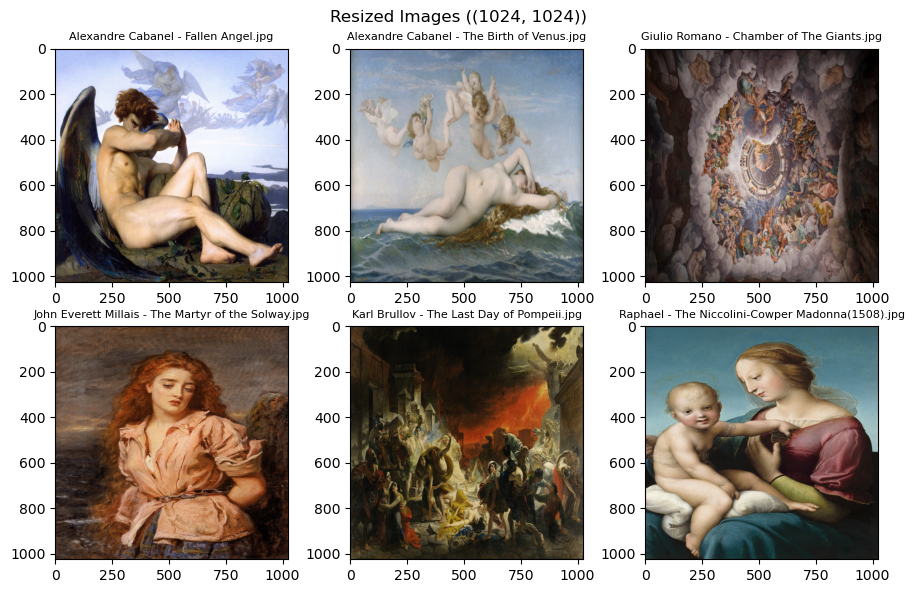

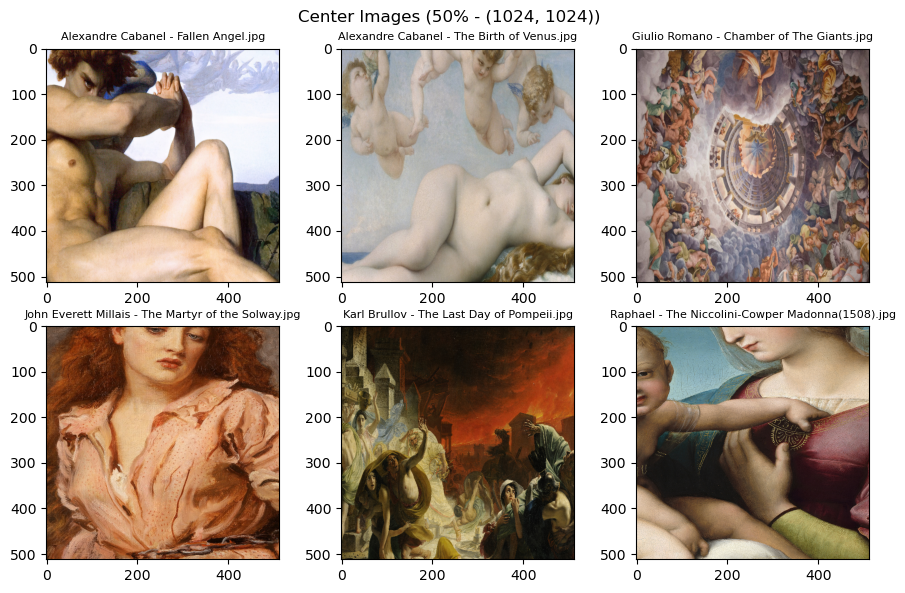

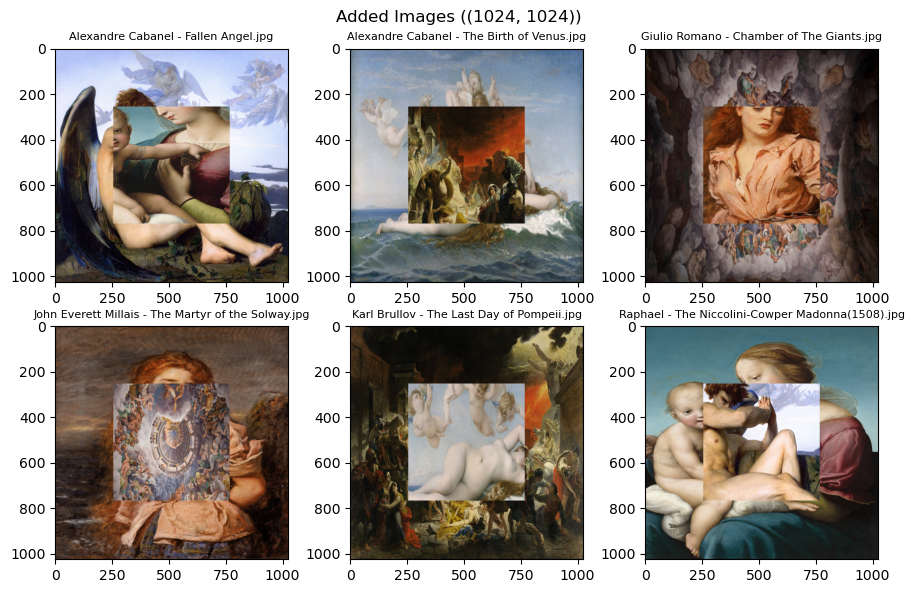

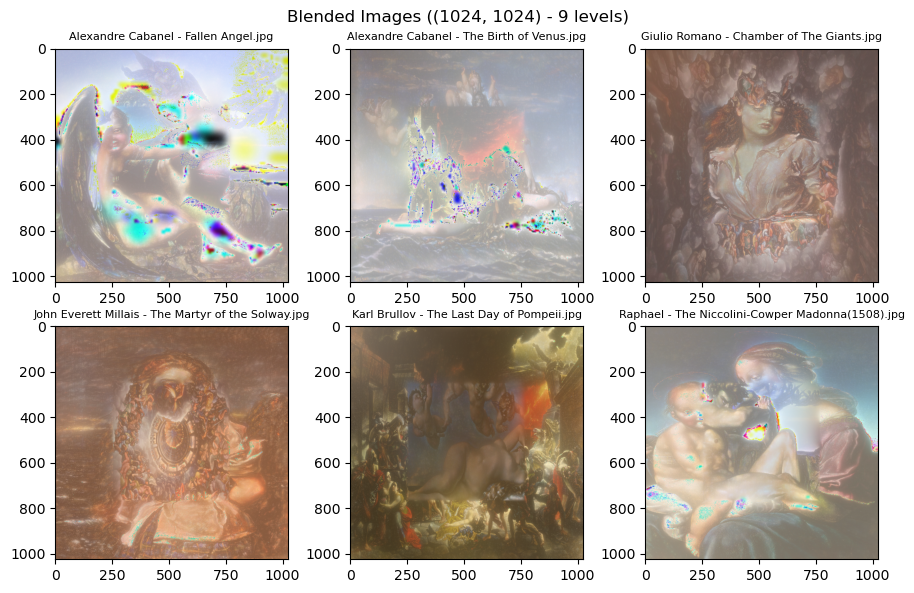

In [81]:
if __name__ == "__main__":
    main()